In [47]:
import matplotlib.pyplot as plt
import cirq
import numpy as np
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import sympy as sp
import pandas as pd

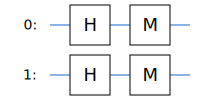

In [48]:
circuit = cirq.Circuit()

qubits = cirq.LineQubit.range(2)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.measure(qubits[0]))
circuit.append(cirq.measure(qubits[1]))

SVGCircuit(circuit)

q(0)=0110101011
q(1)=1011110111


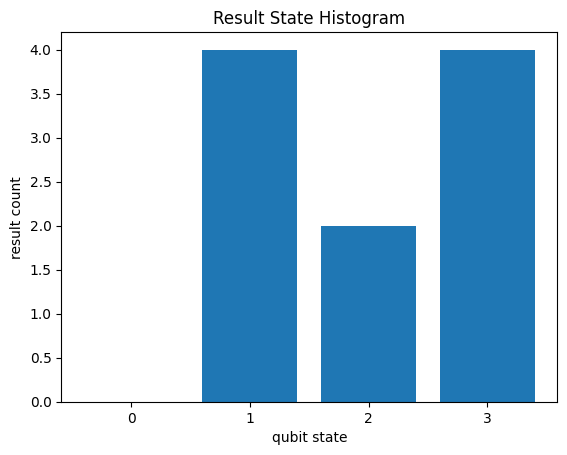

In [49]:
sim = cirq.Simulator()
samples = sim.run(circuit, repetitions = 10)

print(samples)

cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

## 1. Initialization Problem - Max cut
3 nodes, 2 vertices, H2O like figure Max Cut problem and Hamiltonian

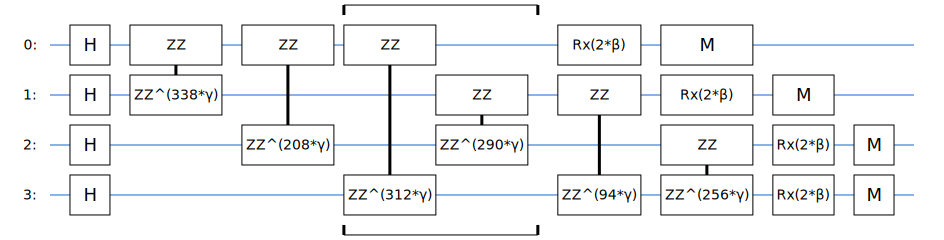

In [136]:
# Define adjacency matrix
weight = np.array([
    [0, 169, 104, 156],
    [0, 0, 145, 47],
    [0, 0, 0, 128],
    [0, 0, 0, 0]
])
node = 4

# Define symbolic parameters
gamma = sp.Symbol("γ")
beta = sp.Symbol("β")

# Create qubits and initialize circuit
qubits = cirq.LineQubit.range(node)
qaoa_circuit = cirq.Circuit()

# Initial Hadamard layer
qaoa_circuit.append([cirq.H(q) for q in qubits])

# Cost Hamiltonian layer (ZZ interactions)
for i in range(node):
    for j in range(i, node):
        if weight[i, j] != 0:
            qaoa_circuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (2 * gamma * weight[i, j]))

# Mixer layer (Rx rotations applied in parallel)
# qaoa_circuit.append(cirq.I(qubits[0]))

qaoa_circuit.append([cirq.rx(2 * beta)(q) for q in qubits])

# Measurement layer
qaoa_circuit.append([
    cirq.measure(q) for q in qubits
])

# Visualize the circuit
SVGCircuit(qaoa_circuit)

## 2. Cost Calculation function and Simple Simulation

In [137]:
def estimate_cost(weight, samples):
    cost_value = 0.0
    node = weight.shape[0]

    # Loop over upper triangle of adjacency matrix
    for i in range(node):
        for j in range(i, node):
            if weight[i, j] != 0:
                i_samples = samples["q(" + str(i) + ")"]
                j_samples = samples["q(" + str(j) + ")"]

                # Convert {0,1} to {+1, -1}
                i_signs = (-1) ** i_samples
                j_signs = (-1) ** j_samples
                term_signs = i_signs * j_signs

                # Expectation value for edge (i,j)
                term_val = np.mean(term_signs) * weight[i, j]
                cost_value += term_val

    return cost_value

In [138]:
gamma_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(qaoa_circuit, params={gamma: gamma_value, beta: beta_value}, repetitions=20000)

sample_results = dict(sample_results)

print(f"Gamma = {round(gamma_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(weight, sample_results)}")

Gamma = 0.785 Beta = 1.571
Estimated cost: 2.6000999999999994


## 3. Iteration over zero to pi values to gamma and beta

In [144]:
import time

start = time.time()
grid_size = 21

def gam_beta_grid(weight, grid_size):
    grid = np.zeros((grid_size, grid_size))
    gamma_sweep = np.linspace(0, np.pi, grid_size)
    print(gamma_sweep)
    beta_sweep = np.linspace(0, np.pi, grid_size)
    print(beta_sweep)
    
    for i in range(grid_size):
        for j in range(grid_size):
            results = sim.sample(qaoa_circuit, params = {gamma : gamma_sweep[i], beta : beta_sweep[j]}, repetitions = 20000)
            results = dict(results)
            cost = estimate_cost(weight, results)
            grid[i, j] = cost
            
    mini, maxi = np.min(grid), np.max(grid)
    min_g, min_b = np.unravel_index(np.argmin(grid), grid.shape)
    min_gam = gamma_sweep[min_g] 
    # https://i.namu.wiki/i/f_q_IqI70RTqi_uiV4x62Y-pB--aJj6WUpDc-JMMTPL8x98fa_RVinXWilRrq6VabEc5WHLo3z3ME6APjRZDgOgHUhwPULFa3XT5P29OSMtr3saevTIeqrjORaZRqBIR1Teb9sSmhi7vB4u4ITUxGw.webp
    min_bet = beta_sweep[min_b]
    return mini, maxi, min_gam, min_bet, grid
        
mini, maxi, min_gam, min_bet, grid = gam_beta_grid(weight, grid_size)
print(mini, maxi, min_gam, min_bet)


end = time.time()

print(end - start)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
-255.0596 139.1413 1.2566370614359172 0.6283185307179586
60.84614706039429


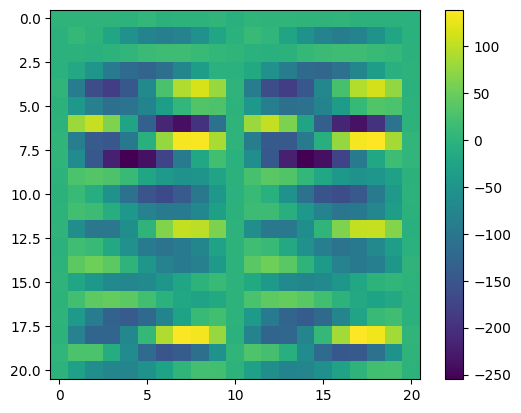

In [145]:
plt.imshow(grid)
plt.colorbar()
plt.show()

## 4. Calculation and Qubit statistic about optimized gamma and beta

In [146]:
gamma_value = min_gam
beta_value = min_bet
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, params={gamma: gamma_value, beta: beta_value}, repetitions=20000
)

sample_results = dict(sample_results)
a = sample_results["q(0)"][5]
print(a)

print(f"Gamma = {round(gamma_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(weight, sample_results)}")

0
Gamma = 1.257 Beta = 0.628
Estimated cost: -253.6243


In [147]:
def histogram_qubits(result, node, repetition):
    qubit_list = {}
    str_qubit = ["q(" + str(i) + ")" for i in range(node)]
    for idx in range(repetition):
        res_qubit = ""
        for jdx in str_qubit:
            res_qubit += str(result[jdx][idx])

        try:
            qubit_list[res_qubit] += 1
        except:
            qubit_list[res_qubit] = 1

    return qubit_list

{'1010': 5569, '0101': 5498, '0100': 1871, '1011': 1835, '0111': 1319, '1000': 1224, '1101': 786, '0010': 758, '0001': 254, '1110': 250, '1001': 190, '0110': 166, '1100': 91, '0011': 66, '0000': 63, '1111': 60}


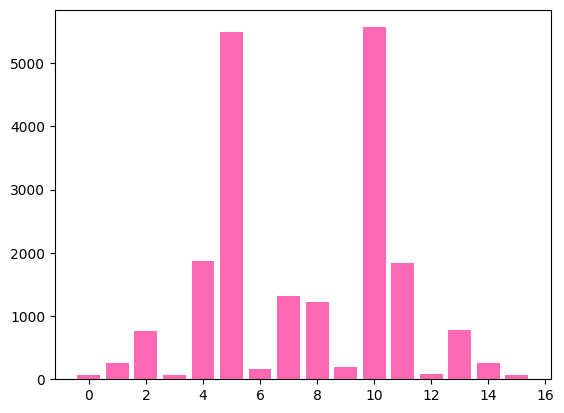

In [148]:
qubit_list = histogram_qubits(sample_results, node, 20000)
sorted_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[0]))
sorted_qubit_list = {int(k, 2): v for k, v in sorted_qubit_list.items()}
ranking_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[1], reverse=True))
print(ranking_qubit_list)

sym = sorted_qubit_list.keys()
val = sorted_qubit_list.values()

name = "Nyx"
plt.bar(sym, val, color = "hotpink")
plt.savefig(f"result/{name}.png")
plt.show()